In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression


from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We are provided hourly rental data along with weather data. We have to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data fields:
- ID - an ID for this instance
- Date - year-month-day
- Hour - Hour of he day
- Temperature - Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)
- y - Rented Bike count (Target), Count of bikes rented at each hour

In [ ]:
train_df= pd.read_csv('train.csv', parse_dates = ['Date'])
#test_df= pd.read_csv('test.csv', parse_dates = ['Date'])

test_df = pd.read_csv('SeoulBikeData.csv',parse_dates = ['Date'])
#t.columns

# info about df like type ..
test_df.head()

,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
test_df.columns

Index(['Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [ ]:
train_df.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [ ]:
# numerice columns in our df 
numerics = ['int64', 'float64']
train_df.select_dtypes(include=numerics).columns

Index(['ID', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [ ]:
#drop duplicates in our df 
print(f"Before Drop Duplicates : {train_df.shape}")
train_df= train_df.drop_duplicates()
test_df= test_df.drop_duplicates()
print(f"After Drop Duplicates : {train_df.shape}")
print("We noticed that df don't have any duplicates :)")

Before Drop Duplicates : (5760, 15)
After Drop Duplicates : (5760, 15)
We noticed that df don't have any duplicates :)


## Another way to Convert our date columns to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%d/%m/%Y")
train_df['Date'].head()

In [ ]:
# Extract day, month and year from date column in train_df
train_df['dayofweek']=train_df['Date'].dt.dayofweek
#train_df['month']=train_df['Date'].dt.month
# train_df['dayofyear']=train_df['Date'].dt.dayofyear

# Extract day, month and year from date column in test_df
test_df['dayofweek']=test_df['Date'].dt.dayofweek
test_df['day']=test_df['Date'].dt.day
# test_df['dayofyear']=test_df['Date'].dt.dayofyear

In [ ]:
test_df = test_df[test_df['day'] >= 21]

In [ ]:
test_df.count()

Date                         3000
y                            3000
Hour                         3000
Temperature(�C)              3000
Humidity(%)                  3000
Wind speed (m/s)             3000
Visibility (10m)             3000
Dew point temperature(�C)    3000
Solar Radiation (MJ/m2)      3000
Rainfall(mm)                 3000
Snowfall (cm)                3000
Seasons                      3000
Holiday                      3000
Functioning Day              3000
dayofweek                    3000
day                          3000
dtype: int64

In [ ]:
#test_df.to_csv('test_new.csv', index=False)

In [ ]:
train_df = train_df[train_df['Functioning Day'] != 'No']

In [ ]:
train_df.count()

ID                           5513
Date                         5513
y                            5513
Hour                         5513
Temperature(�C)              5513
Humidity(%)                  5513
Wind speed (m/s)             5513
Visibility (10m)             5513
Dew point temperature(�C)    5513
Solar Radiation (MJ/m2)      5513
Rainfall(mm)                 5513
Snowfall (cm)                5513
Seasons                      5513
Holiday                      5513
Functioning Day              5513
dayofweek                    5513
dtype: int64

In [ ]:
#del train_df['Functioning Day']

In [ ]:
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,dayofweek
0,0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,3
1,1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,3
2,2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,3
3,3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,3
4,4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,3


In [ ]:
train_df['working_day'] = (train_df['Date'].dt.dayofweek < 5).astype(np.int)
test_df['working_day'] = (test_df['Date'].dt.dayofweek < 5).astype(np.int)

In [ ]:
train_df['work_st_en'] = ((train_df['Date'].dt.dayofweek < 5) & 
                         (((train_df['Hour'] >= 7) &  (train_df['Hour'] <= 9) )|
                         ((train_df['Hour'] >= 17) &  (train_df['Hour'] <= 19)))).astype(np.int)

test_df['work_st_en'] = ((test_df['Date'].dt.dayofweek < 5) & 
                         (test_df['Hour'] >= 7) &  (test_df['Hour'] <= 9) &
                         (test_df['Hour'] >= 17) &  (test_df['Hour'] <= 19)).astype(np.int)

In [ ]:
# use this encoder to encode

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
le = LabelEncoder()

def encode_columns(dataframe, lst_of_col):
    for col in lst_of_col:
        dataframe[col] = le.fit_transform(dataframe[col].values)
        
lst_of_col = ['Seasons',
              'Holiday']

encode_columns(train_df, lst_of_col)
encode_columns(test_df, lst_of_col)

In [ ]:
train_df['Wind speed (m/s)'] = np.log1p(train_df['Wind speed (m/s)'])
test_df['Wind speed (m/s)'] = np.log1p(test_df['Wind speed (m/s)'])

In [ ]:
train_df['Solar Radiation (MJ/m2)'] = np.sqrt(train_df['Solar Radiation (MJ/m2)'])
test_df['Solar Radiation (MJ/m2)'] = np.sqrt(test_df['Solar Radiation (MJ/m2)'])

In [ ]:
train_df['Rainfall(mm)'] = train_df.rolling(2, min_periods=1)['Rainfall(mm)'].mean()
test_df['Rainfall(mm)'] = test_df.rolling(2, min_periods=1)['Rainfall(mm)'].mean()

train_df['dryness'] = 1 / (train_df['Rainfall(mm)'] + 1)
test_df['dryness'] = 1 / (test_df['Rainfall(mm)'] + 1)

In [ ]:
train_df['Snowfall (cm)'] = train_df.rolling(8, min_periods=1)['Snowfall (cm)'].mean()
test_df['Snowfall (cm)'] = test_df.rolling(8, min_periods=1)['Snowfall (cm)'].mean()

train_df['snowing'] = (train_df['Snowfall (cm)'] > 0).astype(np.int)
test_df['snowing'] = (test_df['Snowfall (cm)'] > 0).astype(np.int)

In [ ]:
train_df['invis'] = 2000 - train_df['Visibility (10m)']
test_df['invis'] = 2000 - test_df['Visibility (10m)']


In [ ]:
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),...,Snowfall (cm),Seasons,Holiday,Functioning Day,dayofweek,working_day,work_st_en,dryness,snowing,invis
0,0,2017-01-12,254,0,-5.2,37,1.163151,2000,-17.6,0.0,...,0.0,3,1,Yes,3,1,0,1.0,0,0
1,1,2017-01-12,204,1,-5.5,38,0.587787,2000,-17.6,0.0,...,0.0,3,1,Yes,3,1,0,1.0,0,0
2,2,2017-01-12,173,2,-6.0,39,0.693147,2000,-17.7,0.0,...,0.0,3,1,Yes,3,1,0,1.0,0,0
3,3,2017-01-12,107,3,-6.2,40,0.641854,2000,-17.6,0.0,...,0.0,3,1,Yes,3,1,0,1.0,0,0
4,4,2017-01-12,78,4,-6.0,36,1.193922,2000,-18.6,0.0,...,0.0,3,1,Yes,3,1,0,1.0,0,0


C:\Users\NV Store\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\NV Store\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

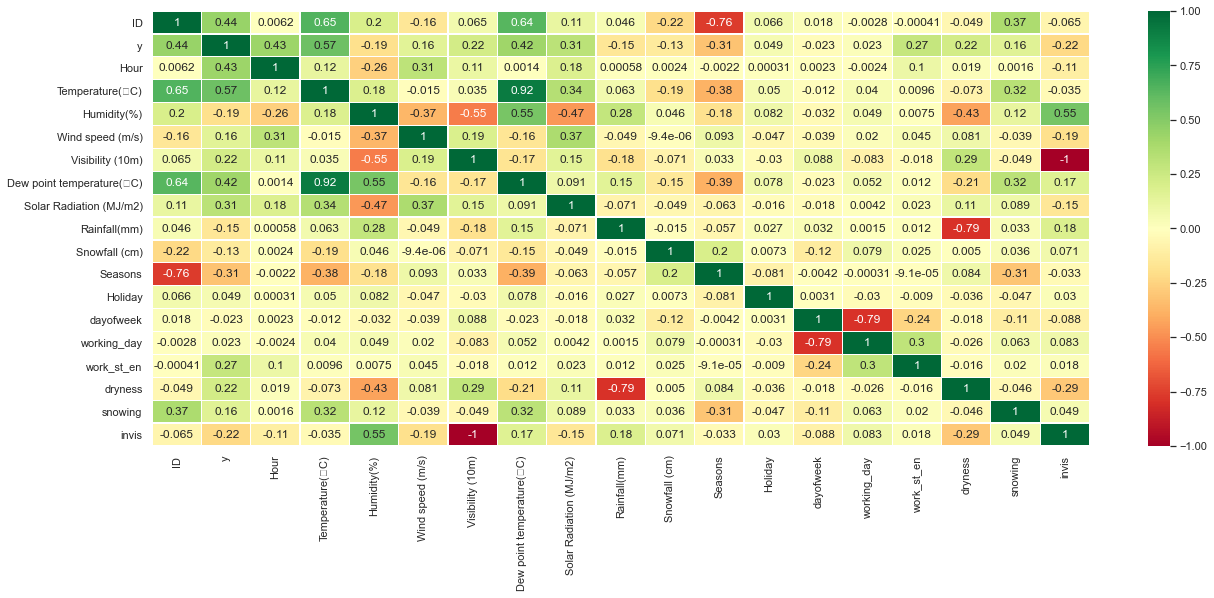

In [ ]:
# dispaly correlation between features or columns in data 
np.random.seed(0)
sns.set_theme()
fig, ax = plt.subplots(figsize = (21, 8))
sns.heatmap(train_df.corr(), cmap ='RdYlGn', linewidths = 0.3, annot = True)

In [ ]:
train_df.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'dayofweek', 'working_day', 'work_st_en',
       'dryness', 'snowing', 'invis'],
      dtype='object')

array([[<AxesSubplot:xlabel='y', ylabel='y'>,
        <AxesSubplot:xlabel='Rainfall(mm)', ylabel='y'>,
        <AxesSubplot:xlabel='Snowfall (cm)', ylabel='y'>,
        <AxesSubplot:xlabel='Solar Radiation (MJ/m2)', ylabel='y'>,
        <AxesSubplot:xlabel='Hour', ylabel='y'>,
        <AxesSubplot:xlabel='Wind speed (m/s)', ylabel='y'>],
       [<AxesSubplot:xlabel='y', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Rainfall(mm)', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Snowfall (cm)', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Solar Radiation (MJ/m2)', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Hour', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Wind speed (m/s)', ylabel='Rainfall(mm)'>],
       [<AxesSubplot:xlabel='y', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Rainfall(mm)', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Snowfall (cm)', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Solar Radiation (MJ/m2)', yl

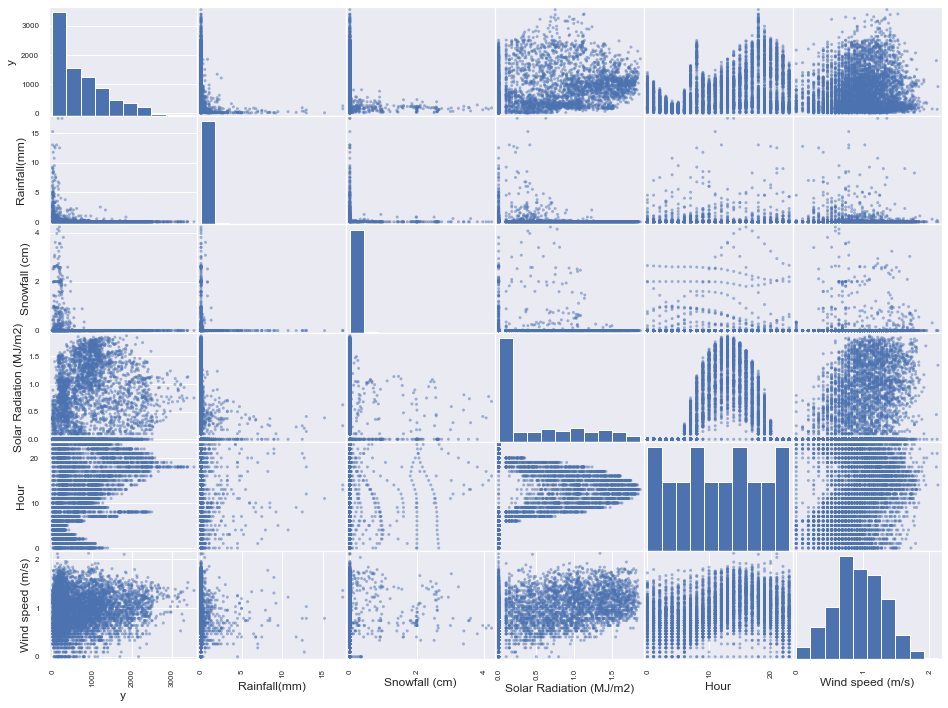

In [ ]:
# display Scatter of some columns in df 
attributes = ['y', 'Rainfall(mm)', 'Snowfall (cm)','Solar Radiation (MJ/m2)','Hour','Wind speed (m/s)']
#category = ['y','Seasons','Holiday', 'Functioning Day','Temperature(�C)','month']
scatter_matrix(train_df[attributes], figsize=(16, 12))
#train_df.hist(figsize=(16, 12))

In [ ]:
# display corr in descending order between y and remaining columns
corr_matrix = train_df.corr()
corr_matrix["y"].sort_values(ascending=False)[1:]

Temperature(�C)              0.574191
ID                           0.438407
Hour                         0.425788
Dew point temperature(�C)    0.418591
Solar Radiation (MJ/m2)      0.313867
work_st_en                   0.274808
dryness                      0.222827
Visibility (10m)             0.222313
snowing                      0.162983
Wind speed (m/s)             0.155980
Holiday                      0.048611
working_day                  0.023248
dayofweek                   -0.022840
Snowfall (cm)               -0.131891
Rainfall(mm)                -0.148479
Humidity(%)                 -0.192091
invis                       -0.222313
Seasons                     -0.314052
Name: y, dtype: float64

In [ ]:
train_df.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'dayofweek', 'working_day', 'work_st_en',
       'dryness', 'snowing', 'invis'],
      dtype='object')

In [ ]:
test_df.columns

Index(['Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'dayofweek', 'day', 'working_day',
       'work_st_en', 'dryness', 'snowing', 'invis'],
      dtype='object')

### Model

In [ ]:
train_df2 = train_df.copy()
X_train2 = train_df.copy().drop(['ID', 'Date', 'y'], axis = 1)
y_train2 = train_df.copy()["y"]

In [ ]:
train_df2.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'dayofweek', 'working_day', 'work_st_en',
       'dryness', 'snowing', 'invis'],
      dtype='object')

In [ ]:
# # select the training features
features = ['Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)','Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Seasons',
        'dayofweek', 'working_day', 
       'dryness', 'snowing', 'invis']

# X_train = X_train[features]
# X_valid = X_valid[features]
X_train2.head()

,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,dayofweek,working_day,work_st_en,dryness,snowing,invis
0,0,-5.2,37,1.163151,2000,-17.6,0.0,0.0,0.0,3,1,Yes,3,1,0,1.0,0,0
1,1,-5.5,38,0.587787,2000,-17.6,0.0,0.0,0.0,3,1,Yes,3,1,0,1.0,0,0
2,2,-6.0,39,0.693147,2000,-17.7,0.0,0.0,0.0,3,1,Yes,3,1,0,1.0,0,0
3,3,-6.2,40,0.641854,2000,-17.6,0.0,0.0,0.0,3,1,Yes,3,1,0,1.0,0,0
4,4,-6.0,36,1.193922,2000,-18.6,0.0,0.0,0.0,3,1,Yes,3,1,0,1.0,0,0


In [ ]:
from xgboost import XGBRegressor 
xgb_model = XGBRegressor(n_estimators=220,objective='count:poisson', max_depth=5, eta=0.22,random_state=51,
                        colsample_bylevel=0.99,colsample_bytree=0.99, gamma=0.1)
xgb_model.fit(X_train2[features], y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.99,
             colsample_bynode=1, colsample_bytree=0.99, eta=0.22, gamma=0.1,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.219999999, max_delta_step=0.699999988, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=220, n_jobs=8, num_parallel_tree=1,
             objective='count:poisson', random_state=51, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# x_batches = np.array_split(X_train2[features], 100)
# y_batches = np.array_split(y_train2, 100)
hist = HistGradientBoostingRegressor(loss="poisson",max_iter=100,learning_rate=0.11,random_state=51
                                 ,warm_start=True,l2_regularization=10)

#for x_batch, y_batch in zip(x_batches, y_batches):
hist.fit(X_train2[features], y_train2)
       # hist.max_iter += 1


HistGradientBoostingRegressor(l2_regularization=10, learning_rate=0.11,
                              loss='poisson', random_state=51, warm_start=True)

In [ ]:
# for i in range(0.9,1,0.01):
#     for j in range(0.9,1,0.01):
#         xgb_model = XGBRegressor(n_estimators=220,objective='count:poisson', max_depth=5, eta=0.22,random_state=51,
#                         colsample_bylevel=0.98,colsample_bytree=0.99, gamma=0.1)
#         xgb_model.fit(X_train2[features], y_train2)
#         y1 = xgb_model.predict(X_test)
#         y1[test_df['Functioning Day'] == 'No'] = 0
#         print("test",np.sqrt(mean_squared_log_error(y_test,y1)))#xgboost

In [ ]:
# predict the number of bikes
from sklearn.metrics import mean_squared_log_error
# Choose the features used for training
X_test = test_df[features]
y_test = test_df['y']

y1 = xgb_model.predict(X_test)
y1[test_df['Functioning Day'] == 'No'] = 0


y2 = hist.predict(X_test)
y2[test_df['Functioning Day'] == 'No'] = 0



#y4 = ereg.predict(X_test)
#y4[test_df['Functioning Day'] == 'No'] = 0


In [ ]:
print("test",np.sqrt(mean_squared_log_error(y_test,y2)))#HistGradientBoostingRegressor

test 0.4951829610513006


In [ ]:
print("test",np.sqrt(mean_squared_log_error(y_test,y1)))#xgboost

test 0.47026555833521155


In [ ]:
y1

array([147.21622, 139.80745, 105.22112, ..., 876.9991 , 874.5678 ,
       610.6929 ], dtype=float32)

In [ ]:
#print("test",np.sqrt(mean_squared_log_error(y_test,y4)))#voting

In [ ]:
#test_df[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)